<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_3_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 3

Before we start, load the following python packages:

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.4 MB/s eta 0:00:00


In [2]:

import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

Cloning into 'DPG_PhysicsBehavior_2026'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 202 (delta 23), reused 6 (delta 3), pack-reused 157 (from 1)
Receiving objects: 100% (202/202), 35.33 MiB | 20.05 MiB/s, done.
Resolving deltas: 100% (92/92), done.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

# Extending to a (slightly) more complex system

for which the longest timescales are not immediate obvious. To do that, we will now move onto a chaotic dynamical system, and see how the ideas introduced in [Notebook 2](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2_toy_dw.ipynb) generalize beyond equilibrium dynamics.

Take the Lorenz equations, a canonical example of the transition to chaos in three dimensional nonlinear dynamics:

$$
\begin{cases}
\dot{x} = \sigma (y - x), \\
\dot{y} = x(\rho - z) - y, \\
\dot{z} = xy - \beta z.
\end{cases}
$$

with $\rho=28$, $\sigma=10$ and $\beta = 8/3$. In this regime, the dynamics is chaotic, and the system relaxes to the iconic butterfly attractor. Let's check a simulation.

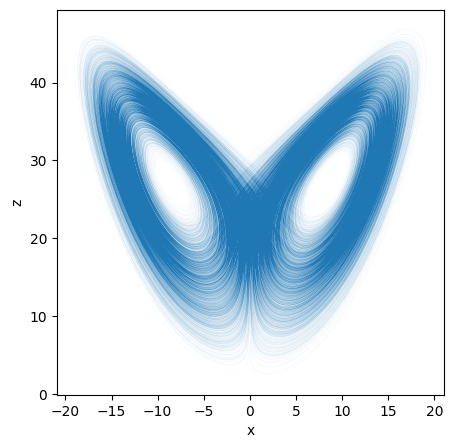

In [4]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.01
frameRate=1/dt
T = 5000
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]
plt.figure(figsize=(5,5))
plt.plot(tseries[:,0],tseries[:,2],lw=.01)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

Unlike the Langevin dynamics in a potential landscape, where the long-term dynamics are dictated by the gradient of the potential, here is it less obvious to determine what the slow modes of the dynamics are.

Fortunately, the Ulam-Galerkin approach introduced in notebook_2 generalizes well to higher dimensions. So let's use it

In [5]:
N=1000
#labels is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels,centers = cl.kmeans_partition(tseries,N,batchsize=10000,return_centers=True)

In [6]:
delay=10 #more on the delay selection in the Appendix
P_emp = op_calc.transition_matrix(labels,delay)
R = op_calc.get_reversible_transition_matrix(P_emp)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
phi2_traj = phi2_emp[labels]

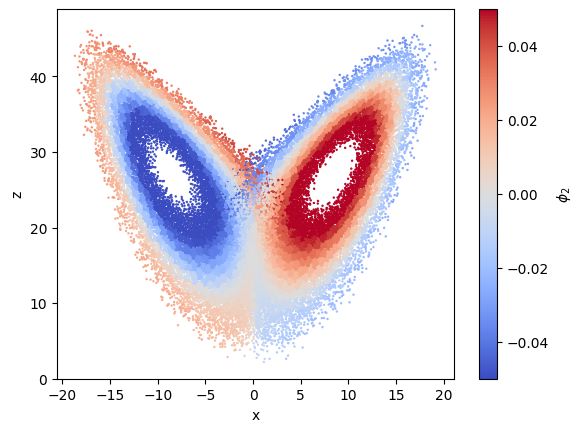

In [54]:
color_abs = np.max(np.abs(phi2_emp))
plt.scatter(tseries[::10,0],tseries[::10,2],c=phi2_traj[::10],cmap='coolwarm',s=0.5,vmin=-.05,vmax=.05)
plt.colorbar(label=r'$\phi_2$')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

So it seems like the slowest mode for the Lorenz attractor identifies almost invariant sets that combine the outer part of one wing to the inner part of another. This means that those transitions are more likely than transition from the outer and inner part of the same wing. You can play around with some simulations to see that, but it's subtle. It becomes way more obvious once we look at the eigenspectrum of the transfer operator.




> Curiosity: It turns out that the separatrix among almost invariant sets follows a higher order fixed point called unstable periodic orbit (UPO), for which $\vec{x}(t+T) \sim \vec{x}(t)$. While the system does not directly visit the unstable periodic orbit, we can find its location by searching for its shadows: trajectories that nearly return to the same point after a time T. We will focus on the shortest UPO, using (Barrio et al. Comput. Phys. Commun. 2015) as a reference.

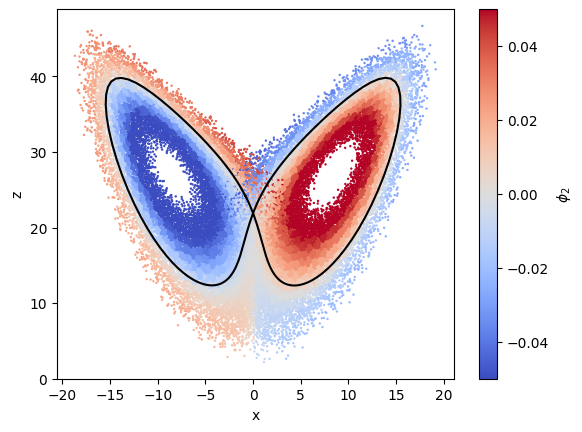

In [55]:
from scipy.signal import find_peaks

eps = .3
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(tseries)-1000,100000):
    dist = 1/(np.linalg.norm(tseries[t_idx+1:t_idx+500]-tseries[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])


t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
plt.plot(tseries[t0:tf+2,0],tseries[t0:tf+2,2],c='k')
plt.scatter(tseries[::10,0],tseries[::10,2],c=phi2_traj[::10],cmap='coolwarm',s=0.5,vmin=-.05,vmax=.05)
plt.colorbar(label=r'$\phi_2$')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

Now, as for the double well potential, we can also directly identify this separatrix by searching along $\phi_2$ and estimating the coherence of the almost invariant sets

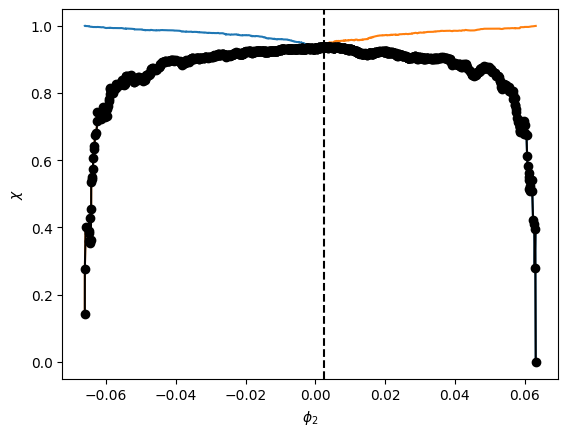

In [9]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

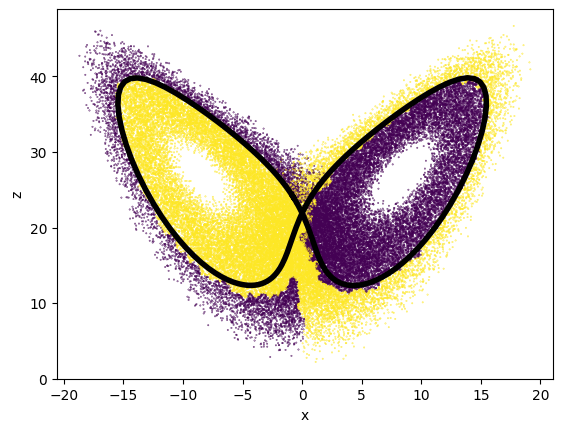

In [56]:
km_labels_traj = km_labels[labels]
plt.scatter(tseries[::10,0],tseries[::10,2],c=km_labels_traj[::10],s=0.1)
plt.plot(tseries[t0:tf+2,0],tseries[t0:tf+2,2],c='k',lw=4)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

And so we obtain an higher order analog the the fixed point separating the two wells in a double well, generalizing also this intuition to dissipative dynamical systems.

# Generalizing to partial observations

In the above calculations we had access to the full state space, which directly provides a Markovian dynamics from which we can directly infer an accurate approximation of the transfer operator.

However, in real-world scenarios we rarely have access to the full set of degrees of freedom, rendering the time evolution of the observed time series non-Markovian. Let's emulate this scenario by working only with the $x$ variable, and see how we can still infer the slow dynamics of the whole system.

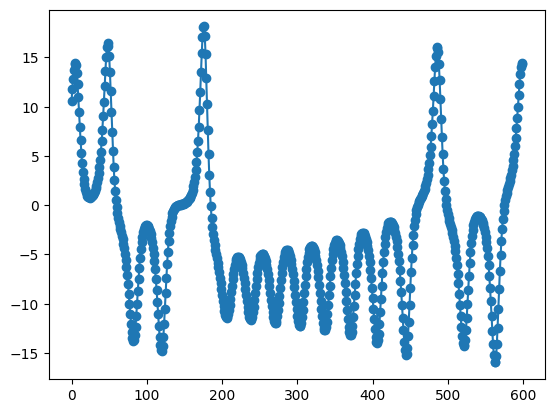

In [59]:
from scipy.integrate import odeint

def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]

dt = 0.02
frameRate=1/dt
T = 2500
discard_T = 500
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]
X = tseries[:,0].reshape(-1,1)
plt.plot(X[:600],marker='o')
plt.show()

When only a single observable $x_t$ is available from an underlying high-dimensional dynamical system, the induced dynamics of $x_t$ are generally non-Markovian, since information about the remaining degrees of freedom is missing. As a result, a Markov model built directly on $x_t$ appears artificially noisy and exhibits a high entropy rate.

However, the missing information is not lost: it is encoded in the temporal correlations of $x_t$. By augmenting the state with time delays,

$$
X_t^{K} = \{x_t, x_{t-1}, \ldots, x_{t-K}\},
$$

one can progressively recover an effective Markovian representation of the dynamics (see, e.g., Sauer et al., J. Stat. Phys., 1991). In this extended state space, the entropy rate

$$
h(N,K) = -\sum_{i,j} \pi_i P_{ij}\log P_{ij}
$$

decreases with increasing $K$, reflecting the recovery of predictive information from the observed time series.

The entropy rate quantifies the average uncertainty per unit time along trajectories. When compared to the entropy of the distribution over states, we get the *predictive information*, which measures how knowing the dynamics reduces the uncertainty over our prediction of the future,

$$
I_\text{pred}(K,N) = H(K,N)-h(K,N),
$$

where $H(K,N) = -\sum_{i,j} \pi_i \log \pi_{i}$ is the entropy of the steady state distribution.

So let's estimate the unpredictability of the dynamics as a function of the number of time delays $K$ and the number of partitions $N$.

In [60]:
from scipy.sparse import diags
npartition_range=np.array(np.logspace(2,3,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(1,12,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(npartition_range)))
Ipred_K=np.zeros((len(range_Ks),len(npartition_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K-1)
    print('created trajectory matrix of shape {}'.format(traj_matrix.shape))
    for kn,N in enumerate(npartition_range):
        labels=cl.kmeans_partition(traj_matrix,N,batchsize=5000)
        #estimate entropy rate
        P = op_calc.transition_matrix(labels,1)
        probs = op_calc.stationary_distribution(P)
        logP = P.copy()
        logP.data = np.log(logP.data)
        h = (-diags(probs).dot(P.multiply(logP))).sum()
        H = (-probs*np.log(probs)).sum()
        Ipred = H-h
        h_K[k,kn]=h
        Ipred_K[k,kn] = Ipred
        print('Computed for {} delays and {} partitions.'.format(K,N))

created trajectory matrix of shape (125000, 1)
Computed for 1 delays and 100 partitions.
Computed for 1 delays and 215 partitions.
Computed for 1 delays and 464 partitions.
Computed for 1 delays and 1000 partitions.
created trajectory matrix of shape (125000, 2)
Computed for 2 delays and 100 partitions.
Computed for 2 delays and 215 partitions.
Computed for 2 delays and 464 partitions.
Computed for 2 delays and 1000 partitions.
created trajectory matrix of shape (125000, 3)
Computed for 3 delays and 100 partitions.
Computed for 3 delays and 215 partitions.
Computed for 3 delays and 464 partitions.
Computed for 3 delays and 1000 partitions.
created trajectory matrix of shape (125000, 4)
Computed for 4 delays and 100 partitions.
Computed for 4 delays and 215 partitions.
Computed for 4 delays and 464 partitions.
Computed for 4 delays and 1000 partitions.
created trajectory matrix of shape (125000, 5)
Computed for 5 delays and 100 partitions.
Computed for 5 delays and 215 partitions.
Compu

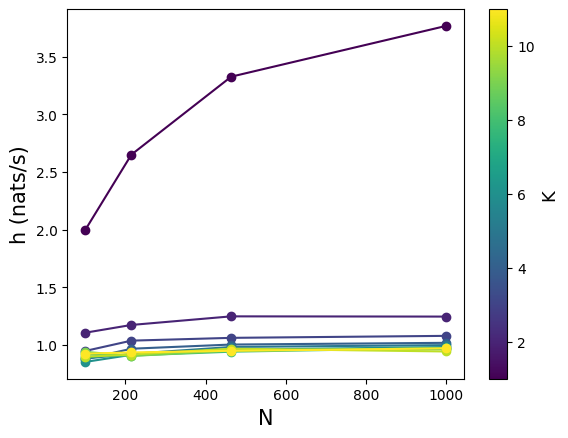

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

fig, ax = plt.subplots()

colors_K = plt.cm.viridis(np.linspace(0, 1, len(range_Ks)))

for k, K in enumerate(range_Ks):
    ax.plot(npartition_range, h_K[k], c=colors_K[k], marker='o')

ax.set_xlabel('N', fontsize=15)
ax.set_ylabel('h (nats/s)', fontsize=15)

# Create colorbar
norm = mpl.colors.Normalize(vmin=min(range_Ks), vmax=max(range_Ks))
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('K', fontsize=13)

plt.show()


As you can see, the entropy generally grows with $N$ is the range that we have looked at, but if you increase $N$ further you will see that the entropy rate will start decaying, reflecting finite-size effects and the inability to populate all partitions properly. This helps defining $N^*$ as the maximum of the entropy rate as a function of $N$, which most faithfully captures the finescale dynamics. In addition, you can see that the entropy decays with $K$: with $K=1$, for which our state is only $x_t$, the inferred Markov chain is very unpredictably, and this unpredictability decays with $K$. Let's see the curve of the entropy and predictive information for a single $K$

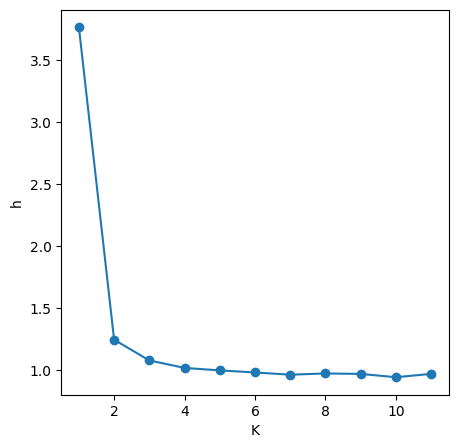

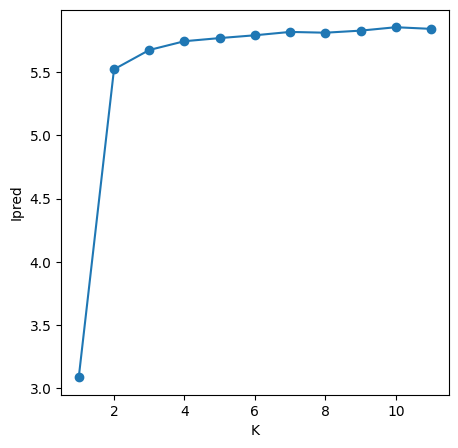

In [65]:
plt.figure(figsize=(5,5))
plt.plot(range_Ks,h_K[:,-1],marker='o')
plt.xlabel('K')
plt.ylabel('h')
plt.show()
plt.figure(figsize=(5,5))
plt.plot(range_Ks,Ipred_K[:,-1],marker='o')
plt.ylabel('Ipred')
plt.xlabel('K')
plt.show()

Beyond $K\approx 5\,\text{frames}$, we see no gains in predictability with including more time delays. Let's then set $K^*=7\,\text{frames}$ to reconstruct the state space, and then infer the transfer operator eigenvalues and eigenvectors.

In [66]:
K_star=7
traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K_star-1)

In [67]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(traj_matrix,N,batchsize=50000,return_centers=True)

In [68]:
delay=10
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp)
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
phi2_traj = ma.masked_invalid(phi2_emp)[labels_all]
phi2_traj[labels_all.mask]=ma.masked

To visualize the trajectory matrix, we will project into 2 dimensions using singular value decomposition.

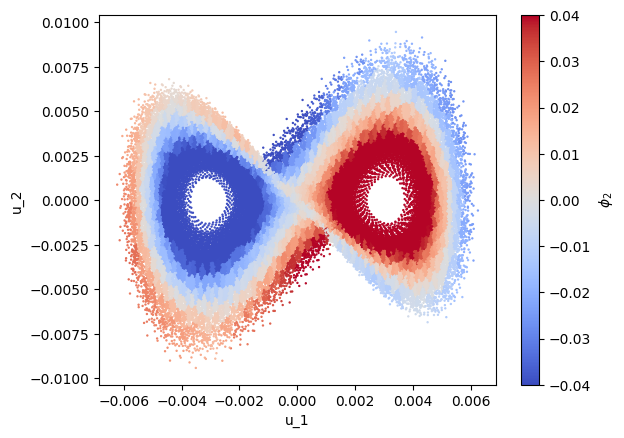

In [73]:
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)
color_abs = np.max(np.abs(phi2_emp))
sel = ~phi2_traj.mask
plt.scatter(u[sel,0],u[sel,1],c=phi2_traj[sel],cmap='coolwarm',s=0.5,vmin=-.04,vmax=.04)
plt.colorbar(label=r'$\phi_2$')
plt.xlabel('u_1')
plt.ylabel('u_2')
plt.show()

As you can see, while the geometry of the reconstructed state space is different from the original $\{x,y,z\}$ state, it seems to perserve the topological properties of the dynamics with $\phi_2$ effectively capturing transitions among almost invariant sets.

As before, we can identify the UPO that corresponds to the separatrix of the dynamics

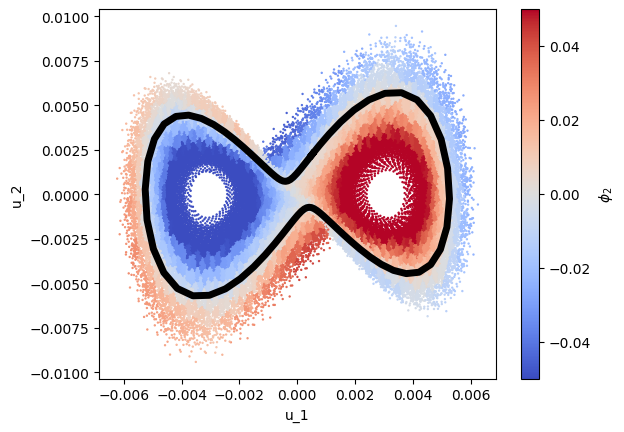

In [74]:
from scipy.signal import find_peaks

eps = .3
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(tseries)-1000,100000):
    dist = 1/(np.linalg.norm(tseries[t_idx+1:t_idx+500]-tseries[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])

t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
plt.plot(u[t0:tf+2,0],u[t0:tf+2,1],c='k',lw=5)
sel = ~phi2_traj.mask
plt.scatter(u[sel,0],u[sel,1],c=phi2_traj[sel],cmap='coolwarm',s=0.5,vmin=-.05,vmax=.05)
plt.colorbar(label=r'$\phi_2$')
plt.xlabel('u_1')
plt.ylabel('u_2')
plt.show()

Analogously, we can also discover the separatrix among almost invariant sets using the coherence measure along $\phi_2$.

In [75]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

Let's plot the coherence for each macroscopic set $S^+(\phi_2^c)$ (blue) and $S^-(\phi_2^c)$ (orange) as well as the minimum among the two (black).

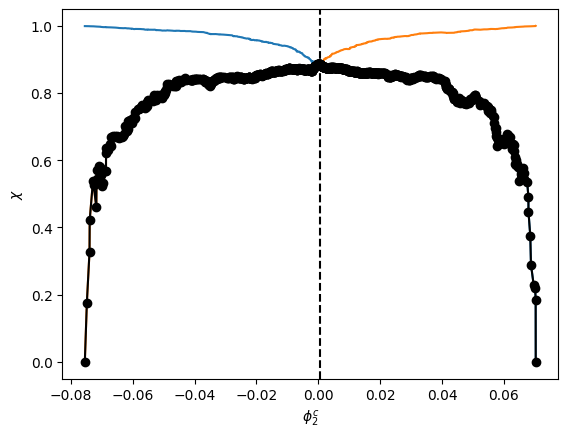

In [123]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2^c$')
plt.show()

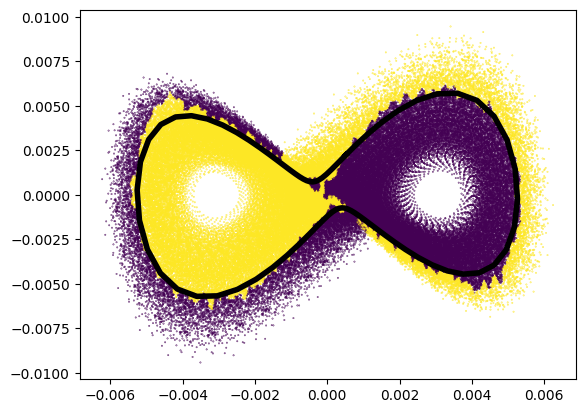

In [77]:
km_labels_traj = ma.masked_invalid(km_labels)[labels_all]
km_labels_traj[labels_all.mask] = ma.masked
sel = ~km_labels_traj.mask
plt.scatter(u[sel,0],u[sel,1],c=km_labels_traj[sel],s=0.1)
plt.plot(u[t0:tf+2,0],u[t0:tf+2,1],c='k',lw=4)
# plt.colorbar()
plt.show()

To illustrate how the dynamics projected along $\phi_2$ are slow, let's compare them with the time series of $x_t$.

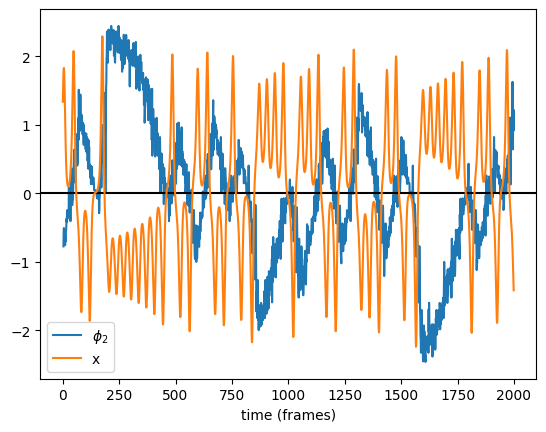

In [79]:
plt.plot(phi2_traj[:2000]/phi2_traj[:2000].std(),label=r'$\phi_2$')
plt.axhline(cr[idx],c='k')
plt.plot(X[:2000,0]/(X[:,0].std()),label='x')
plt.legend()
plt.xlabel('time (frames)')
plt.show()

# Appendix 1 - $\tau$ selection

As described in the Appendix of [Notebook 2](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2_toy_dw.ipynb), once we discretize the state space, we need to carefully choose $\tau$, to find an appropriate spectral gap.

Let's estimate the eigenvalues $\lambda_k$ and implied timescales $t^\text{imp}_k$ as a function of the delay $\tau$.



In [122]:
delay_range = np.unique(np.array(np.logspace(0,3,200),dtype=int))
n_modes=5
eigvals_delay = np.zeros((len(delay_range),n_modes))
tscales_delay = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  R = op_calc.get_reversible_transition_matrix(P_emp)
  eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=n_modes+1)
  timps=-delay*dt/np.log(eigvals_emp[1:].real)
  tscales_delay[kd] = timps
  eigvals_delay[kd] = eigvals_emp[1:].real

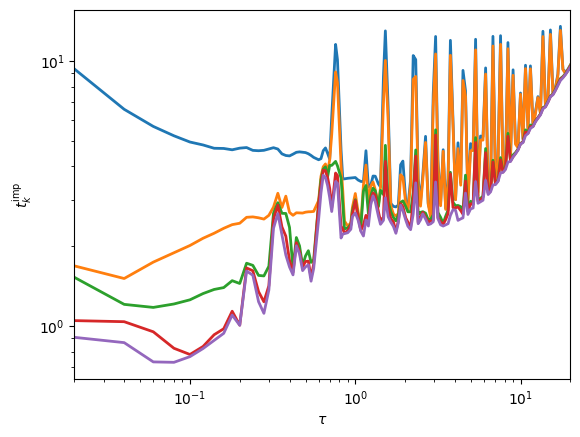

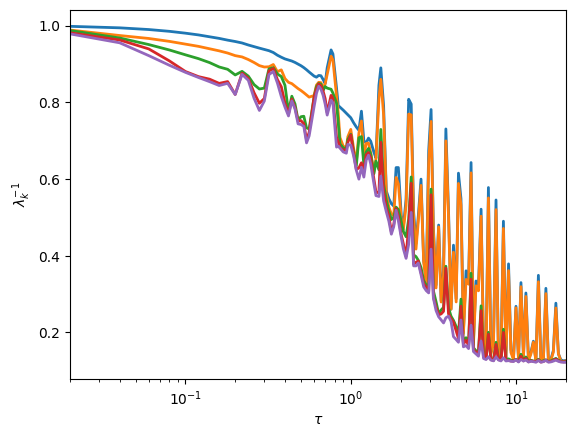

In [120]:
plt.plot(delay_range*dt,tscales_delay,lw=2)
plt.ylabel(r'$t^\text{imp}_k$')
plt.xlabel(r'$\tau$')
plt.xscale('log')
plt.yscale('log')
plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
plt.show()

plt.plot(delay_range*dt,eigvals_delay,lw=2)
plt.ylabel(r'$\lambda_k^{-1}$')
plt.xlabel(r'$\tau$')
plt.xscale('log')
plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
plt.show()

Crazy looking stuff uh? Do you wanna give it a shot an interpreting the result?

Here's the explanation, for short $\tau$ the transition matrix is too close to an identity matrix and the eigenvalues are collapsed at 1, leading to an overestimation of the overall implies timescales. At very large $\tau$, we start seeing the linear growth of $t^\text{imp}_k$ with $\tau$ that indicates that the dynamics has mixed. However, we also see peaks of eigenvalues at specific timescales. These reflect the quasi-periodic nature of the dynamics and the spectrum of unstable periodic orbits: when the transition time is comparable to the period of unstable periodic orbits, it's almost as if we go back to the $\tau→0$ limit. This becomes apparent if we also plot the period of UPOs:


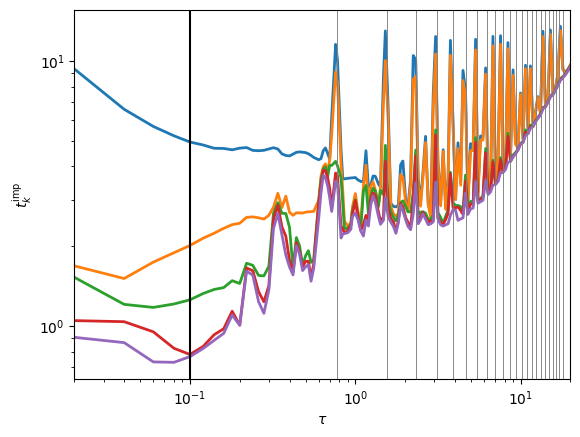

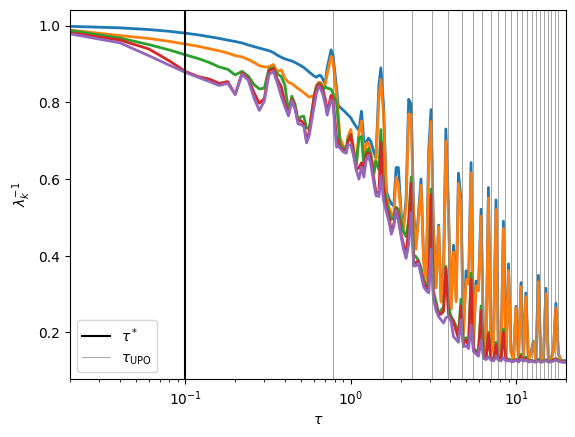

In [121]:
T_UPO_ref = 1.5586522107161747275678702092126960705284/2

plt.plot(delay_range*dt,tscales_delay,lw=2)
plt.ylabel(r'$t^\text{imp}_k$')
plt.xlabel(r'$\tau$')

for k in range(1,24):
  plt.axvline(k*T_UPO_ref,c='gray',lw=.5)
plt.xscale('log')
plt.yscale('log')
plt.axvline(0.1,c='k',label=r'$\tau^*$')
plt.axvline(T_UPO_ref,c='gray',lw=.5,label=r'$\tau_\text{UPO}$')
for k in range(2,24):
  plt.axvline(k*T_UPO_ref,c='gray',lw=.5)
plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)

plt.show()

plt.plot(delay_range*dt,eigvals_delay,lw=2)
plt.ylabel(r'$\lambda_k^{-1}$')
plt.xlabel(r'$\tau$')
plt.xscale('log')
# plt.yscale('log')
plt.axvline(0.1,c='k',label=r'$\tau^*$')
plt.axvline(T_UPO_ref,c='gray',lw=.5,label=r'$\tau_\text{UPO}$')
for k in range(2,24):
  plt.axvline(k*T_UPO_ref,c='gray',lw=.5)
plt.legend()
plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
plt.show()

We thus choose $\tau^*=0.1\,\text{s}$, in a regime where the implied timescale are approximately flat and in between the two pathological limits.